In [8]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
import en_core_web_lg # python -m spacy download en_core_web_lg
import matplotlib.pyplot as plt
from keras.layers import TextVectorization, Embedding, LSTM, Dense, Bidirectional, Input
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.initializers import Constant
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from utils import stratified_split
from preprocessing import preprocess_df

In [9]:
model_dir = 'models'
model_name = 'bilstm_classifier.keras'
params_dict = {'dropout': 0.3,
                'rec_dropout': 0.3,
                'learning_rate': 0.006,
                'patience': 4,
                'units': 128,
                'batch': 256,
                'epochs': 15}

In [10]:
def get_x_y(df: pd.DataFrame, feature: str='preprocessed_text', target_class: str='generated'):
    x = df[feature]
    y = np.array(df[target_class]).astype('float32').reshape((-1,1))
    
    return x, y

In [11]:
df = pd.read_csv('data/preprocessed_df.csv', header=0)
df.head()

,title,text,generated,preprocessed_text
0,Sexhow railway station,Sexhow railway station was a railway station b...,0,sexhow railway station railway station built s...
1,Etiäinen,"In Finnish folklore, all places and things, an...",0,finnish folklore place thing also human being ...
2,Inverse function theorem,"In mathematics, specifically differential calc...",0,mathematics specifically differential calculus...
3,Stepping on Roses,is a Japanese shōjo manga series written and i...,0,japanese shōjo manga series written illustrate...
4,Rob Bradley,"Robert Milner ""Rob"" Bradley, Jr. (born August ...",0,robert milner rob bradley born august 1970 gre...


In [12]:
train_set, valid_set, test_set = stratified_split(df)

# shuffle rows
train_set = train_set.sample(frac=1).reset_index(drop=True)
test_set = test_set.sample(frac=1).reset_index(drop=True)
valid_set = valid_set.sample(frac=1).reset_index(drop=True)

x_train, y_train = get_x_y(train_set)
x_valid, y_valid = get_x_y(valid_set)
x_test, y_test = get_x_y(test_set)

In [13]:
nlp = en_core_web_lg.load()
Vectorizer = TextVectorization()

In [14]:
train_valid_data = pd.DataFrame(pd.concat([x_train, x_valid], axis=0))

In [15]:
#fit the vectorizer on the text and extract the corpus vocabulary
Vectorizer.adapt(train_valid_data['preprocessed_text'].to_numpy())
vocab = Vectorizer.get_vocabulary()

In [16]:
#generate the embedding matrix
num_tokens = len(vocab)
embedding_dim = len(nlp('The').vector) #300
embedding_matrix = np.zeros((num_tokens, embedding_dim))
print(num_tokens, embedding_dim)
cnt_oov = 0
for i, word in enumerate(vocab):
    doc = nlp(str(word))
    embedding_matrix[i] = doc.vector
    if doc and doc[0].is_oov:
        cnt_oov += 1

444006 300


In [17]:
cnt_oov / num_tokens * 100

79.81964207690886

In [18]:
#Load the embedding matrix as the weights matrix for the embedding layer and set trainable to False
Embedding_layer=Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False)

In [19]:
model = Sequential()
model.add(Input(shape=(1,), dtype=tf.string))
model.add(Vectorizer)
model.add(Embedding_layer)
model.add(Bidirectional(LSTM(units=params_dict['units'],
                            recurrent_dropout=params_dict['rec_dropout'],)))
                            # return_sequences=True)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
            optimizer=Adam(learning_rate=params_dict['learning_rate']),
            metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 300)      │   133,201,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,641,353 (509.80 MB)

 Trainable params: 439,553 (1.68 MB)

 Non-trainable params: 133,201,800 (508.12 MB)

In [20]:
callback = EarlyStopping(
            monitor="val_loss",
            patience=params_dict['patience'],
            restore_best_weights=True)

history = model.fit(x_train,
                    y_train,
                    validation_data=(x_valid, y_valid),
                    verbose=1,
                    batch_size=params_dict['batch'],
                    epochs=params_dict['epochs'],
                    callbacks=[callback])

Epoch 1/15


352/352 ━━━━━━━━━━━━━━━━━━━━ 152s 425ms/step - accuracy: 0.7061 - loss: 0.5320 - val_accuracy: 0.8468 - val_loss: 0.3571
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 149s 423ms/step - accuracy: 0.8518 - loss: 0.3396 - val_accuracy: 0.8688 - val_loss: 0.3038
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 204s 430ms/step - accuracy: 0.8754 - loss: 0.2921 - val_accuracy: 0.8807 - val_loss: 0.2837
Epoch 4/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 202s 429ms/step - accuracy: 0.8845 - loss: 0.2760 - val_accuracy: 0.8879 - val_loss: 0.2720
Epoch 5/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 153s 434ms/step - accuracy: 0.8924 - loss: 0.2575 - val_accuracy: 0.8885 - val_loss: 0.2683
Epoch 6/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 202s 434ms/step - accuracy: 0.8979 - loss: 0.2478 - val_accuracy: 0.8954 - val_loss: 0.2518
Epoch 7/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 202s 435ms/step - accuracy: 0.9064 - loss: 0.2281 - val_accuracy: 0.9006 - val_loss: 0.2395
Epoch 8/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 151s 429ms/step - accuracy: 0.9130 - loss: 0.21

In [21]:
model.save(os.path.join(model_dir, model_name))

In [22]:
model_loaded = load_model(os.path.join(model_dir, model_name))

In [23]:
def get_predictions_bilstm(model, x_test):
    predictions = model.predict(x_test)
    predictions = np.where(predictions.max(axis=-1) > 0.5, 1, 0)
    return predictions

In [24]:
def acc_loss(history):
    # Visualize Loss & Accuracy

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

def conf_matrix(y_true, y_pred):
    cm = confusion_matrix(np.array(y_true), y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

In [25]:
def validate_model_bilstm(model, history, x_test, y_true):
    print('#### VALIDATION ####')
    print('Test set evaluation:')
    model.evaluate(x_test, y_true, verbose=1)

    y_pred = get_predictions_bilstm(model, x_test)
    print('Classification report:')
    print(classification_report(y_true, y_pred))

    acc_loss(history)
    conf_matrix(y_true, y_pred.flatten())

#### VALIDATION ####
Test set evaluation:
  9/938 ━━━━━━━━━━━━━━━━━━━━ 37s 41ms/step - accuracy: 0.7056 - loss: 0.7676

938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.6975 - loss: 0.8449
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step
Classification report:
              precision    recall  f1-score   support

         0.0       0.86      0.48      0.61     15000
         1.0       0.64      0.92      0.75     15000

    accuracy                           0.70     30000
   macro avg       0.75      0.70      0.68     30000
weighted avg       0.75      0.70      0.68     30000



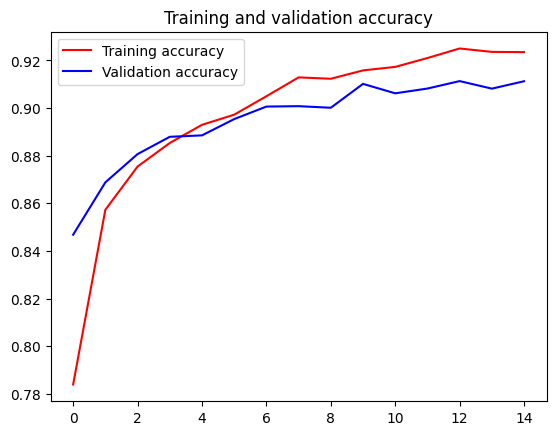

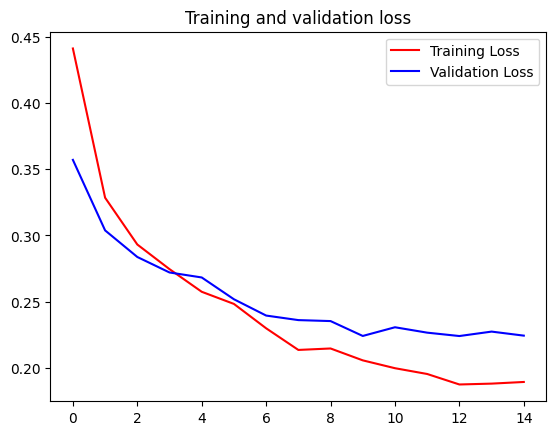

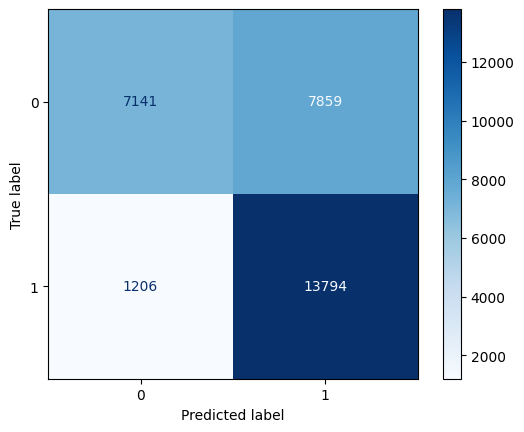

In [26]:
validate_model_bilstm(model_loaded, history, x_test, y_test)

# Predicting on Different Data

In [27]:
def get_extra_data(path):
    #load to df
    data = pd.read_pickle(path)
    data = pd.DataFrame({'text': data})
    # add labels
    labels = np.ones(data.shape[0])
    data['generated'] = labels
    return data

In [28]:
def validate_predictions_bilstm(model, x_test, y_true):
    print('#### VALIDATION ####')

    y_pred = get_predictions_bilstm(model, x_test)
    print('Classification report:')
    print(classification_report(y_true, y_pred, zero_division=0))

    conf_matrix(y_true, y_pred.flatten())

In [29]:
def predict_data(model, data):
    # prepare data
    data = preprocess_df(data)
    x = data['preprocessed_text']
    y = np.array(data['generated'])
    
    validate_predictions_bilstm(model, x, y)

#### VALIDATION ####
  1/450 ━━━━━━━━━━━━━━━━━━━━ 1:13 164ms/step

450/450 ━━━━━━━━━━━━━━━━━━━━ 68s 151ms/step
Classification report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.59      0.74     14400

    accuracy                           0.59     14400
   macro avg       0.50      0.30      0.37     14400
weighted avg       1.00      0.59      0.74     14400



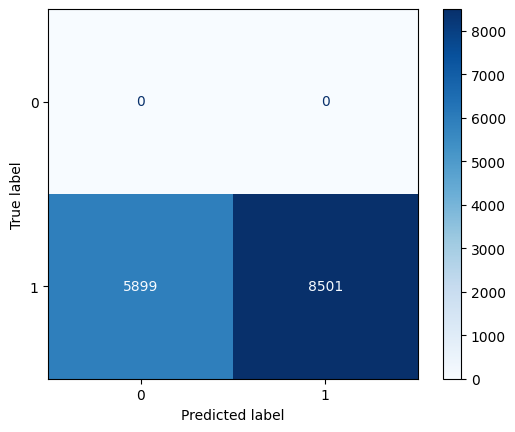

In [30]:
df_chatgpt = get_extra_data('data/extras/chat_gpt.pkl')
predict_data(model_loaded, df_chatgpt)

#### VALIDATION ####
 96/450 ━━━━━━━━━━━━━━━━━━━━ 55s 157ms/step

450/450 ━━━━━━━━━━━━━━━━━━━━ 67s 149ms/step
Classification report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.63      0.78     14400

    accuracy                           0.63     14400
   macro avg       0.50      0.32      0.39     14400
weighted avg       1.00      0.63      0.78     14400



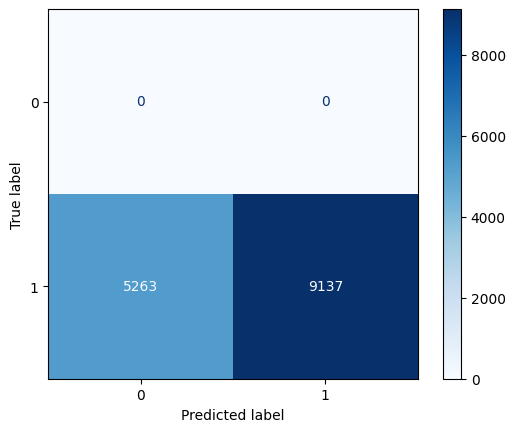

In [31]:
df_davinci = get_extra_data('data/extras/davinci.pkl')
predict_data(model_loaded, df_davinci)

#### VALIDATION ####
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.42      0.60      1375
           1       0.00      0.67      0.01         3

    accuracy                           0.43      1378
   macro avg       0.50      0.55      0.30      1378
weighted avg       1.00      0.43      0.59      1378



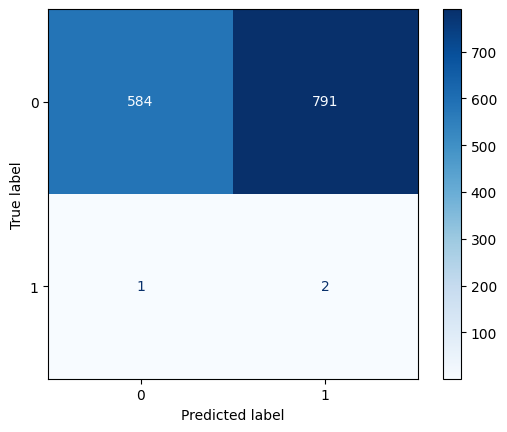

In [32]:
df_essays = pd.read_csv('data/extras/train_essays.csv', header=0)
predict_data(model_loaded, df_essays)

In [33]:
df_palm = pd.read_csv('data/extras/LLM_generated_essay_PaLM.csv', header=0)
df_falcon = pd.read_csv('data/extras/falcon_180b_v1.csv', header=0)
df_llama = pd.read_csv('data/extras/llama_70b_v1.csv', header=0)

df_llama.rename(columns={'generated_text': 'text'}, inplace=True)
df_falcon.rename(columns={'generated_text': 'text'}, inplace=True)

df_falcon['generated'] = np.ones(df_falcon.shape[0])
df_llama['generated'] = np.ones(df_llama.shape[0])

df_extras = pd.concat([df_palm[['text', 'generated']], df_falcon[['text', 'generated']], df_llama[['text', 'generated']]], axis=0)
print(df_extras.shape)
df_extras.head()

(3611, 2)


,text,generated
0,## The Advantages of Limiting Car Usage\n\nIn ...,1.0
1,"The United States is a car-dependent nation, w...",1.0
2,"In recent years, there has been a growing move...",1.0
3,"In recent years, there has been a growing move...",1.0
4,"In the past few decades, the United States has...",1.0


#### VALIDATION ####
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step
Classification report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.44      0.61      3611

    accuracy                           0.44      3611
   macro avg       0.50      0.22      0.31      3611
weighted avg       1.00      0.44      0.61      3611



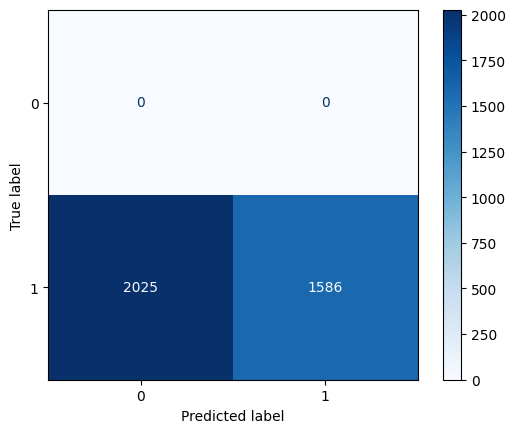

In [34]:
predict_data(model_loaded, df_extras)

# BiLSTM with Gensim FastText
https://www.kaggle.com/code/guichristmann/lstm-classification-model-with-word2vec
https://www.kaggle.com/code/nikzzzn/lstm-nn-fasttext-embedding

In [27]:
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional, Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import l1, l2
from keras.optimizers import Adam

from gensim.models import FastText

from utils import stratified_split, get_x_y

In [28]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [10]:
MAX_SEQ_LEN = 128 #try 256 as well

In [2]:
# Loading dataset
df = pd.read_csv('data/preprocessed_df.csv', header=0)

In [5]:
train_set, valid_set, test_set = stratified_split(df)

# shuffle rows
train_set = train_set.sample(frac=1).reset_index(drop=True)
test_set = test_set.sample(frac=1).reset_index(drop=True)
valid_set = valid_set.sample(frac=1).reset_index(drop=True)

x_train, y_train = get_x_y(train_set)
x_valid, y_valid = get_x_y(valid_set)
x_test, y_test = get_x_y(test_set)

In [6]:
train_valid_set = pd.concat([train_set, valid_set], axis=0)

In [15]:
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(train_valid_set['preprocessed_text'])
sequences = tokenizer.texts_to_sequences(train_valid_set['preprocessed_text'])
word_index = tokenizer.word_index
data = sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding = 'post')

In [29]:
fasttext_model = FastText(vector_size=200, alpha=0.025, window=5, min_count=1, workers=4)
fasttext_model.build_vocab(data)
fasttext_model.train(data, total_examples=len(data), epochs=12)
fasttext_model.save("models/FastText_file_200.bin")

# fasttext_model=FastText.load("/kaggle/input/fasttext-model/FastText_file.bin")

2024-05-07 19:21:29,472 : INFO : FastText lifecycle event {'params': 'FastText<vocab=0, vector_size=200, alpha=0.025>', 'datetime': '2024-05-07T19:21:29.472389', 'gensim': '4.3.2', 'python': '3.11.9 (main, Apr 19 2024, 16:48:06) [GCC 11.2.0]', 'platform': 'Linux-5.10.0-27-amd64-x86_64-with-glibc2.31', 'event': 'created'}
2024-05-07 19:21:29,474 : INFO : collecting all words and their counts
2024-05-07 19:21:29,474 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-05-07 19:21:29,660 : INFO : PROGRESS: at sentence #10000, processed 1280000 words, keeping 83315 word types
2024-05-07 19:21:29,858 : INFO : PROGRESS: at sentence #20000, processed 2560000 words, keeping 130615 word types
2024-05-07 19:21:30,062 : INFO : PROGRESS: at sentence #30000, processed 3840000 words, keeping 170768 word types
2024-05-07 19:21:30,269 : INFO : PROGRESS: at sentence #40000, processed 5120000 words, keeping 206924 word types
2024-05-07 19:21:30,478 : INFO : PROGRESS: at senten

KeyboardInterrupt: 